In [95]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from matplotlib import pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
# Cargamos el dataset en una variable que se llama data
# Es simplemente una lista de strings. Cada string un texto

# List of sentences
data = [
    "He is the son of his father",
    "The man and the boy are enjoying themselves",
    "Male siblings include brothers and sons",
    "Uncles often play with their nephews",
    "She is a caring mother to her daughter",
    "The woman and the girl are enjoying themselves",
    "Female siblings include sisters and pretty daughters",
    "Aunts are often close to their nieces",
    "His devious actions were bizarre and venomous",
    "The erratic behavior was frightening and himself deceitful",
    "The barbaric act was forceful and deceptive. Hello world",
    "Envious, plump and greedy, he showed him hateful contempt",
    "The brutal and monstrous actions were calculating and cruel",
    "Intolerant and aggressive behavior is monstrous",
]

# Crear los sets para calculasr los sesgos
# Las listas tipo A y B son palabras de dos campos semanticos contrastantes
# Las listas tipo C son palabras objetivos
A_man = ["he", "son", "his", "him", "father", "man", "boy", "himself", "male",
         "brother", "sons", "fathers", "men", "boys", "males", "brothers",
         "uncle", "uncles", "nephew", "nephews"]
B_woman = [
          "she", "daughter", "hers", "her", "mother", "woman", "girl",
           "herself", "female", "sister", "daughters", "mothers", "women",
           "girls", "females", "sisters", "aunt", "aunts", "niece",
           "nieces"
           ]

C_personality = [
    "devious", "bizarre", "venomous", "erratic", "barbaric", "frightening", "deceitful",
    "forceful", "deceptive", "envious", "greedy", "hateful", "contemptible", "brutal", "monstrous", "calculating",
    "cruel", "intolerant", "aggressive", "monstrous"
]

C_appearence = [
    "alluring", "voluptuous", "blushing", "homely", "plump", "sensual", "gorgeous", "slim", "bald", "athletic",
    "fashionable", "stout", "ugly", "muscular", "slender", "feeble", "handsome", "healthy", "attractive", "fat",
    "weak", "thin", "pretty", "beautiful", "strong"
]

AS = [A_man, A_man]
BS = [B_woman, B_woman]
CS = [C_personality, C_appearence]

In [97]:
nltk.download('punkt')
nltk.download('stopwords')

# Defininmos el corpus a usar
texts = data

# Tokenizamos los textos
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Removemos las stop words y la puntuacion
stop_words = set(stopwords.words('english'))
tokenized_texts = [
    [word for word in tokens if word.isalnum() and word not in stop_words]
    for tokens in tokenized_texts
]

# Definimos el modelo Word2Vec
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Lo entrenamos
model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)

# Accedemos a los embeddings
word_embeddings = model.wv

# Lista de las palabras procesadas
all_words = word_embeddings.key_to_index.keys()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


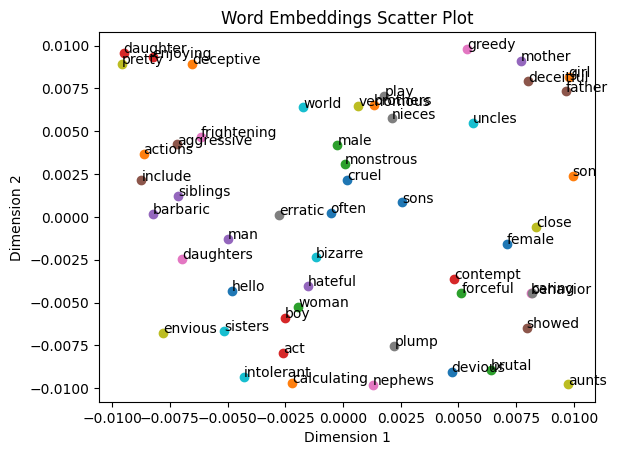

In [98]:
# Plot the embeddings for all words
for word in all_words:
    embedding = word_embeddings[word]
    plt.scatter(embedding[0], embedding[1], marker='o')
    plt.text(embedding[0], embedding[1], word)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.show()

In [99]:
def get_bias_df_from_ABC(A, B, C):
  # Create a DataFrame to store the bias values
  bias_df = pd.DataFrame(columns=["Word in C", "CStoA", "CStoB"])
  control_embeddings = {}

  for word in all_words:
      if word in A or word in B or word in C:
        control_embeddings[word] = np.array([[word_embeddings[word][0]], [word_embeddings[word][1]]])

  # Calculate bias for each word in C
  for word_c in C:
      if word_c in all_words:

          # Calculate the mean similarity between word 'c' and words in set A
          cosine_similarities_a = [cosine_similarity(control_embeddings[word_c].reshape(1, -1), control_embeddings[word].reshape(1, -1))[0][0] for word in set(A).intersection(set(all_words))]
          mean_similarity_a = np.mean(cosine_similarities_a)

          # Calculate the mean similarity between word 'c' and words in set B
          cosine_similarities_b = [cosine_similarity(control_embeddings[word_c].reshape(1, -1), control_embeddings[word].reshape(1, -1))[0][0] for word in set(B).intersection(set(all_words))]
          mean_similarity_b = np.mean(cosine_similarities_b)

          # Calculate the bias for word 'c'
          bias = mean_similarity_a - mean_similarity_b

          # Append the result to the DataFrame
          bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)

  # Print the table
  bias_df = bias_df.sort_values(by='Bias', ascending=False)
  return bias_df


<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)
<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)
<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)
<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method i

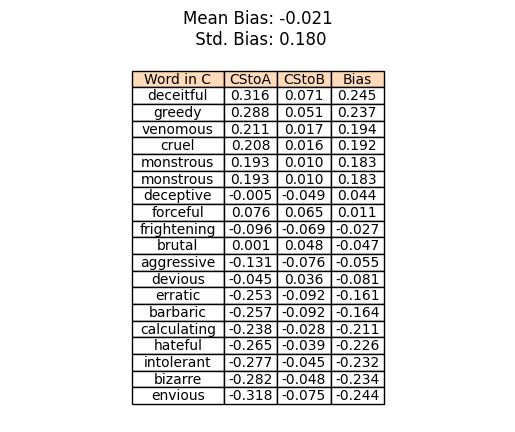

<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)
<ipython-input-99-4cf5290f1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_df = bias_df.append({"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}, ignore_index=True)


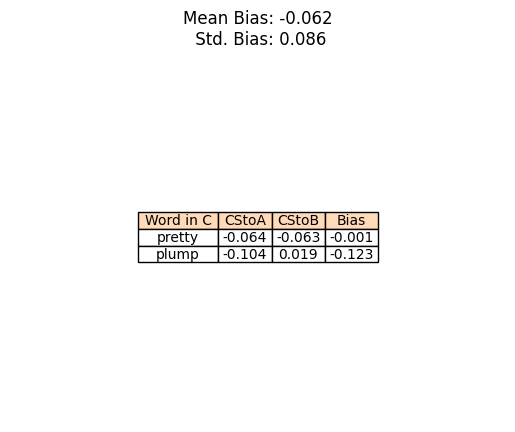

In [116]:
for A, B, C in zip(AS, BS, CS):

  df = get_bias_df_from_ABC(A, B, C)  #FFDAB9

  # Create a figure and axis
  fig, ax = plt.subplots()

  # Hide the axes
  ax.axis('off')

  def format_as_string(value):
      return f'{value:.3f}' if isinstance(value, (int, float)) else str(value)

  dfo = df
  df = df.applymap(format_as_string)


  # Add a table to the axes
  table = ax.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='center',
                  colColours=['#FFDAB9']*len(df.columns),
                  cellColours=[['w']*len(df.columns)]*(len(df)))

  # Adjust the layout to make room for the table
  table.auto_set_font_size(False)
  table.set_fontsize(10)

  # Adjust column widths
  table.auto_set_column_width([i for i in range(len(df.columns))])

  mean_bias = dfo['Bias'].mean()
  std_bias = dfo['Bias'].std()
  plt.title(f'Mean Bias: {mean_bias:.3f}\n Std. Bias: {std_bias:.3f}')

  # Show the plot
  plt.show()



